In [56]:

import pandas as pd
import numpy as np
import tensorflow

import gym
import matplotlib.pyplot as plt
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate,LSTM ,Reshape
from keras import optimizers #import Adam
from keras import layers,models
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


In [62]:

dianna = pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\dianna.csv',
                     parse_dates={'date': ['Date']}, na_values=-1)
print('Dianna is ready:\n')
dianna.info()
dianna.dropna(inplace=True)
dianna = dianna.reset_index()

raw = dianna.drop(columns=['index', 'date', 'nth day in year'])
rawd = dianna.drop(columns=['index', 'date', 'nth day in year', 'Outflow (cusecs)'])
print('\nRaw and RawD is reADY\n')


lookback = 5
i = 0


class final(gym.Env):
    metadata = {
        'render.modes': ['human']
    }

    def step(self, a):
        done=False
        self.action = a
        outflow_factor = 0.0864
        inflow_factor = 0.0864
        EVAPORATION = 0
        flag=0
        res = self.state[4][0] - EVAPORATION + (raw.iloc[lookback + self.count, 1] * inflow_factor) - (a * outflow_factor)
        if res < 0:
            res = 0
            #done=True
            flag=1
        nextt = np.array(self.state[1:]).tolist()
        nextt.append([res, raw.iloc[lookback + self.count, 1], raw.iloc[lookback + self.count, 2],a])
        self.state = np.array(nextt)
        if flag==1:
            self.reward=-1000
        elif a < 0:
            done=True
            self.reward = -1000
        elif res > 3000:
            self.bad_day += 1
            self.reward = -10
            
        elif a>=120:
            self.good_day+=1
            self.reward=(a//12)
        else:
            self.bad_day += 1
            if(a==0):
                    self.reward = -(12//1)
            else:
                    self.reward = -(12//a)


        self.count += 1

        return self.state, self.reward, (self.count >= len(raw) - lookback)or done, {}

    def __init__(self, seed=0):
        self.DEMAND_THRESHOLD = 120
        self.MAX_CAPACITY = 3000
        self.action = 0.
        self.count = seed
        self.good_day = 0
        self.bad_day = 0
        self.reward = 0

        lookback = 5
        self.next_state = np.zeros((lookback, raw.shape[-1]))

        sequence = np.zeros((lookback, raw.shape[-1]))
        for j in range(0, lookback):
            sequence[j] = raw.loc[seed + j, :]
        self.state = sequence

        a = []
        for i in range(lookback):
            a.append([0., 0., 0., 0.])
        self.low = np.array(a, dtype=np.float32)

        a = []
        for i in range(lookback):
            a.append([4000., 100000., 1000., 100000.])
        self.high = np.array(a, dtype=np.float32)
        self.action_space = spaces.Box(
            low=0,
            high=100000, shape=(1,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=self.low,
            high=self.high,
            dtype=np.float32
        )

    def reset(self, seed=0):
        self.DEMAND_THRESHOLD = 100
        self.MAX_CAPACITY = 3000
        self.action = 0.
        self.count = seed
        self.good_day = 0
        self.bad_day = 0
        self.reward = 0
        self.next_state = np.zeros((lookback, raw.shape[-1]))
        sequence = np.zeros((lookback, raw.shape[-1]))
        for j in range(0, lookback):
            sequence[j] = raw.loc[seed + j, :]
        self.state = sequence
        return self.state

    def render(self, mode='human'):
        print('',end='')
print('gym ready')

Dianna is ready:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5844 entries, 0 to 5843
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5844 non-null   datetime64[ns]
 1   nth day in year   5844 non-null   int64         
 2   Storage (mcft)    5830 non-null   float64       
 3   Inflow (cusecs)   5830 non-null   float64       
 4   Rainfall (mm)     5830 non-null   float64       
 5   Outflow (cusecs)  5816 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 274.1 KB

Raw and RawD is reADY

gym ready


In [58]:
'''
plt.clf()
import matplotlib.pyplot as plt
for ij in range(0,10):
    
    i=ij*365
    j=i
    a=[]
    env=final(i)
    state=env.reset(i)
    done=False
    while(not done and i!=j+365):
            #print(i)
            state,reward,done,_=env.step(raw.iloc[lookback+i,3])
            #print(state[4][0],done)
            a.append(state[4][0])
            #score+=reward
            i+=1
    plt.figure(figsize=(10,10))
    plt.plot(range(j,i),a)
    plt.plot(range(j,i),raw.iloc[j+lookback:i+lookback,0])
    plt.show()
'''

'\nplt.clf()\nimport matplotlib.pyplot as plt\nfor ij in range(0,10):\n    \n    i=ij*365\n    j=i\n    a=[]\n    env=final(i)\n    state=env.reset(i)\n    done=False\n    while(not done and i!=j+365):\n            #print(i)\n            state,reward,done,_=env.step(raw.iloc[lookback+i,3])\n            #print(state[4][0],done)\n            a.append(state[4][0])\n            #score+=reward\n            i+=1\n    plt.figure(figsize=(10,10))\n    plt.plot(range(j,i),a)\n    plt.plot(range(j,i),raw.iloc[j+lookback:i+lookback,0])\n    plt.show()\n'

In [59]:
env = final()
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]


input1=Input(shape=(1,) + env.observation_space.shape, name='GV_observation_input')
flatu=Reshape((5,4),name='GV_flatu')(input1)
lstm1=LSTM(32,
                        dropout=0.1,
                        recurrent_dropout=0.5,name='GV_LSTM')(flatu)
                        
output=Dense(nb_actions,activation='relu',name='output')(lstm1)

gv = Model(inputs=input1, outputs=output)
gv.compile(loss='mae', optimizer=optimizers.RMSprop())
print('GyanaVEL summary:\n\n')
print(gv.summary())



action_input = Input(shape=(nb_actions,), name='ESH_action_input')
observation_input = Input(shape= (1,) +env.observation_space.shape, name='ESH_observation_input')
flattened_observation = Flatten(name='ENV_flatu')(observation_input)
x = Concatenate(name='ENV_adder')([action_input, flattened_observation])
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(16)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
esh = Model(inputs=[action_input, observation_input], outputs=x)
print('\n\nESHvari summary:\n\n')
print(esh.summary())


GyanaVEL summary:


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GV_observation_input (InputL (None, 1, 5, 4)           0         
_________________________________________________________________
GV_flatu (Reshape)           (None, 5, 4)              0         
_________________________________________________________________
GV_LSTM (LSTM)               (None, 32)                4736      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
None


ESHvari summary:


Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to              

In [60]:
memory = SequentialMemory(limit=1000, window_length=1)
agent = DDPGAgent(nb_actions=nb_actions, actor=gv, critic=esh, critic_action_input=action_input,
                  memory=memory,random_process=None,gamma=.99,
                 )


agent.compile(optimizers.RMSprop(), metrics=['mae'])
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=len(raw)-lookback)

# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format('ENV_NAME'), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
#agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)

Training for 50000 steps ...
Interval 1 (0 steps performed)
 3997/10000 [==========>...................] - ETA: 1:43 - reward: -10.3765done, took 68.795 seconds



Year  2004
Progress: -------------------------------------------------------------------------------------------------------------------------------------------------

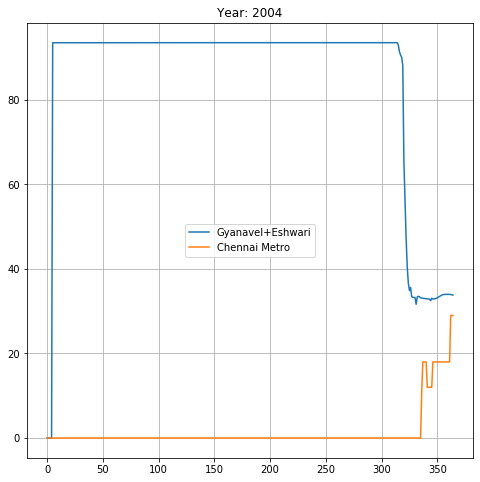


Year  2005
Progress: ----------------------------------------------------------------------------------------------------------------------------------------

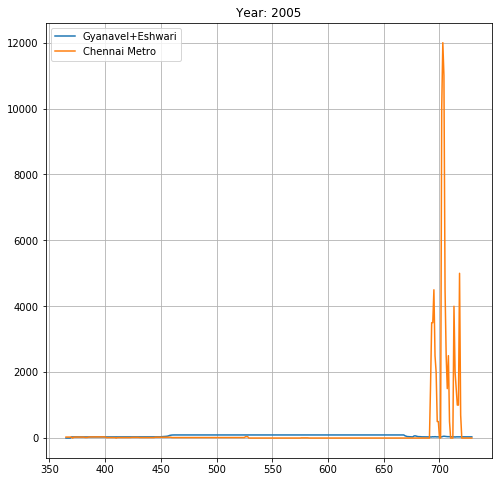


Year  2006
Progress: -------------------------------------------------------------------------------------------------------------------------------

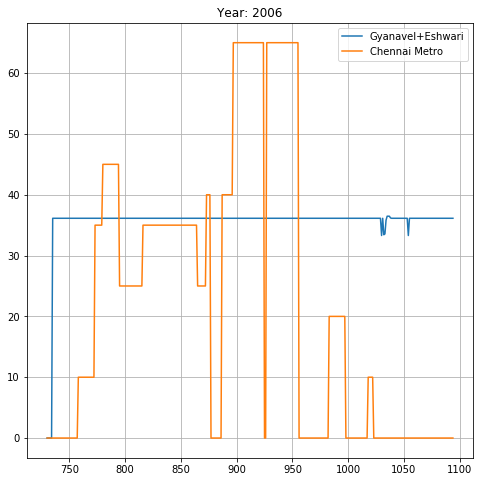


Year  2007
Progress: ----------------------------------------------------------------------------------------------------------------------

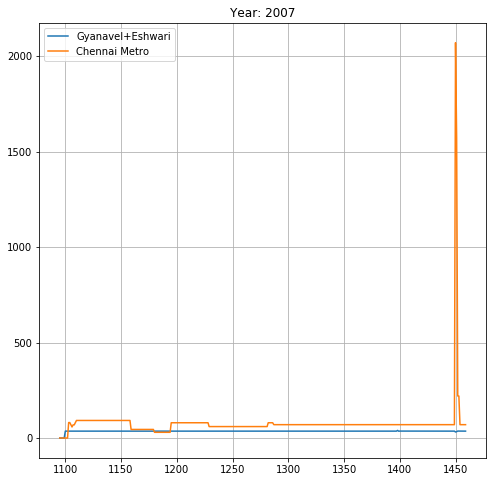


Year  2008
Progress: -------------------------------------------------------------------------------------------------------------

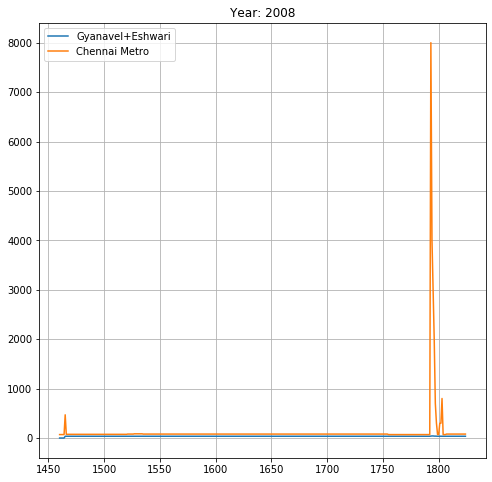


Year  2009
Progress: ----------------------------------------------------------------------------------------------------

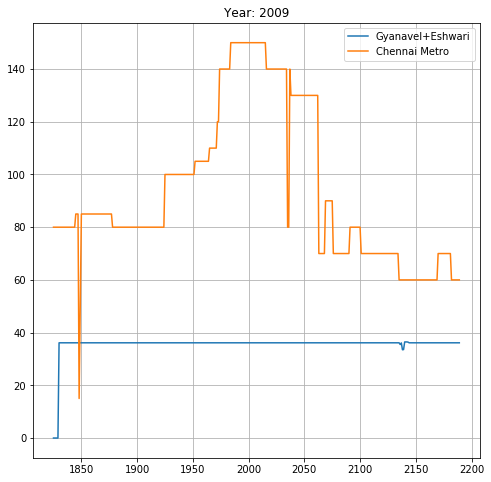


Year  2010
Progress: -------------------------------------------------------------------------------------------

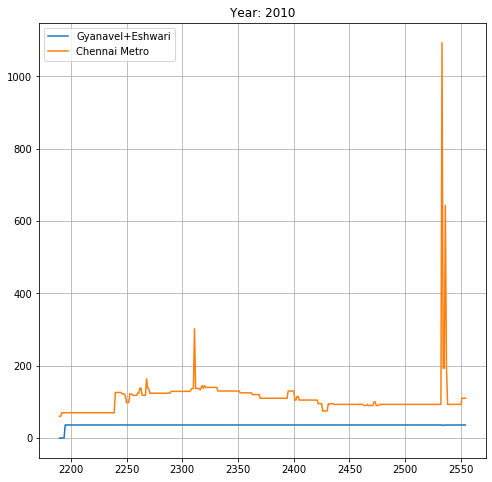


Year  2011
Progress: ----------------------------------------------------------------------------------

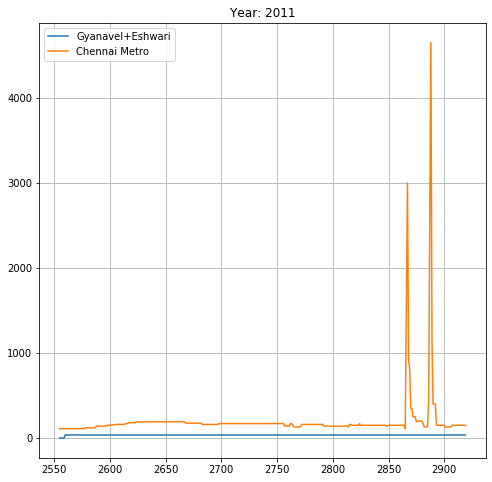


Year  2012
Progress: ------------------------------------------------------------------------

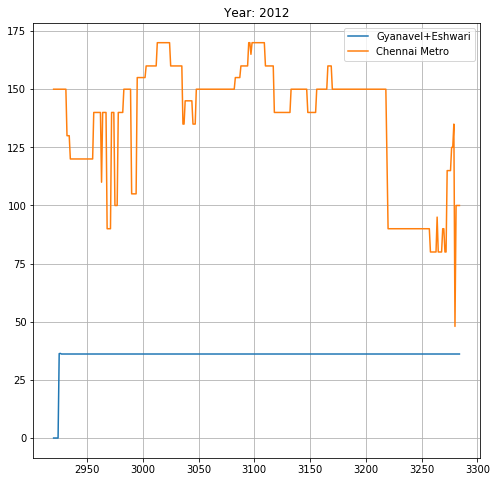


Year  2013
Progress: ---------------------------------------------------------------

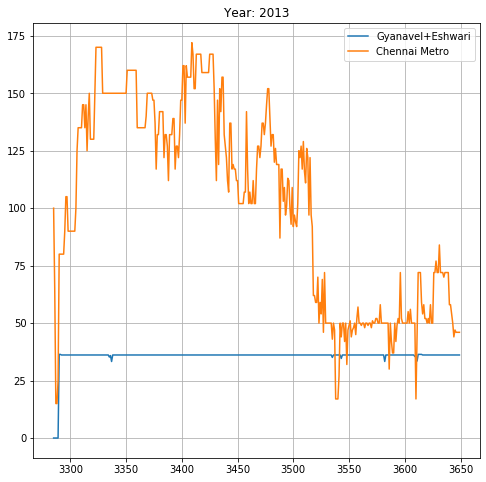

In [63]:
for ij in range (0,10):

    seed=365*ij

    vne=final()
    state2=vne.reset(seed)
    
    done=False
    done2=False
   
    i=lookback+seed
    b=[]
    for _ in range(lookback+seed):
        b.append(0.0)
    
    
    print('\nYear ',2004+ij)
    print('Progress:',end=' ')
    while(not done and not done2 ):
        action=gv.predict(np.array([[state2]]))[0][0]
        state2,reward2,done2,_=vne.step(action)
        b.append(action)
         
        if(i%40==0):
            print('-',end='')
        i+=1
        if(i>=len(raw)):
            break
    
    
    start=seed
    end=start+365
    if(start+365>len(raw)):
        end=len(raw)
    plt.figure(figsize=(8,8))
    plt.plot(range(start,end),b[start:end])
    plt.plot(range(start,end),raw.iloc[start:end,3])
    plt.legend(['Gyanavel+Eshwari','Chennai Metro'])
    
    plt.title('Year: '+str(2004+ij))
    plt.grid()

    plt.show()


In [38]:
gv.predict(np.array([[vne.reset(3995)]]))

array([[0.]], dtype=float32)